# **TUGAS AKHIR**
Pada penelitian ini akan dilakukan pencarian model yang mampu mendeteksi 2 kelas diabetes retinopati (No DR dan Proliferative DR)

## Data4

Dataset : C:/Dani/Kuliah/TA/Git/data4

Link Dataset :
[Diabetes Retinopati](https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy)


### Import Lib

In [6]:
# General Libs
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import tensorflow as tf
import cv2
import glob, os

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from keras.models import Model
from keras.activations import relu
from keras.backend import softmax, sigmoid
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import f_oneway
import time

select distinct pd_kodepromosi, 
                                            cba_kodecabang as kodecabang, 
                                            cab_namacabang as namacabang,
                                            cab_singkatancabang, 
                                            prd_prdcd,
                                            prd_deskripsipendek,
                                            prd_hrgjual,
                                            (select cbt_targetqty as target from tbtr_cashback_target where cbt_kodepromosi = cbh_kodepromosi and cbt_kodeigr = cba_kodecabang and cbt_prdcd = cbd_prdcd) as target,
                                            (select cbt_targetsales as targetrph from tbtr_cashback_target where cbt_kodepromosi = cbh_kodepromosi and cbt_kodeigr = cba_kodecabang and cbt_prdcd = cbd_prdcd) as targetrph,
                                            (select cbt_growth from tbtr_cashback_target where cbt_kodepromosi = cbh_kodepromosi and cbt_kode

### Image Data Generator

In [2]:
train_path = 'C:/Dani/Kuliah/TA/Git/data4/train'
valid_path = 'C:/Dani/Kuliah/TA/Git/data4/val'
test_path = 'C:/Dani/Kuliah/TA/Git/data4/test'

In [3]:
image_size = (224,224)
batch_size = 16
class4 = ['No_DR', 'DR']

datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    preprocessing_function=None
)

# no dr - proliferative
print("\nNo DR - DR")
print("Train : ")
train_generator_nodr_prodr = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class4,
    shuffle=True
)

print("Validation : ")
valid_generator_nodr_prodr = datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class4,
    shuffle=True
)

print("Test : ")
test_generator_nodr_prodr = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class4,
    shuffle=True
)


No DR - DR
Train : 
Found 2274 images belonging to 2 classes.
Validation : 
Found 285 images belonging to 2 classes.
Test : 
Found 279 images belonging to 2 classes.


### Development Phase : VGG19 - Percobaan 5

In [4]:
input_shape = train_generator_nodr_prodr.image_shape

lr = 0.0001
steps_per_epoch = 40
epochs = 20
validation_steps = 30

In [5]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### MODEL

In [6]:
def VGG19 (input_shape) :

    x_input = Input(input_shape, name="input_layer") #VGG19 input_shape by default is (64,64,1)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1")(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1")(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1")(x) #1
    x = Dense(4096, activation=relu, name="fc2")(x) #2
    x = Dense(1, activation=sigmoid, name="predictions")(x) #3
    #n_class = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG19")

    return model

#### Compile and Train Model

In [7]:
model_VGG = VGG19(input_shape)
model_VGG.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

In [8]:
start = time.time()
history_VGG_nodr_prodr_data6 = model_VGG.fit(
      train_generator_nodr_prodr,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator_nodr_prodr,
      validation_steps = validation_steps,
      verbose=1)
end = time.time()
print("Time for learning: ", (end-start))

Epoch 1/20


40/40 [==============================] - 662s 16s/step - loss: 0.6925 - accuracy: 0.5375 - val_loss: 0.6781 - val_accuracy: 0.5018
Epoch 2/20
40/40 [==============================] - 568s 14s/step - loss: 0.5003 - accuracy: 0.7719
Epoch 3/20
40/40 [==============================] - 570s 14s/step - loss: 0.2921 - accuracy: 0.8859
Epoch 4/20
40/40 [==============================] - 568s 14s/step - loss: 0.2951 - accuracy: 0.8969
Epoch 5/20
40/40 [==============================] - 566s 14s/step - loss: 0.2060 - accuracy: 0.9187
Epoch 6/20
40/40 [==============================] - 617s 15s/step - loss: 0.2436 - accuracy: 0.8891
Epoch 7/20
40/40 [==============================] - 549s 14s/step - loss: 0.2595 - accuracy: 0.9047
Epoch 8/20
40/40 [==============================] - 546s 14s/step - loss: 0.2013 - accuracy: 0.9266
Epoch 9/20
40/40 [==============================] - 531s 13s/step - loss: 0.2194 - accuracy: 0.9329
Epoch 10/20
40/40 [==============================] - 543s 14s/step - 

#### Save Model

In [19]:
history_VGG_nodr_prodr_data6.model.save("VGG19_nodr_prodr_data6.h5")

C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Evaluate

In [9]:
# loaded_vgg16 = load_model('VGG16.h5')

VGG16_loss, VGG16_accuracy = history_VGG_nodr_prodr_data6.model.evaluate(train_generator_nodr_prodr, steps=50)
print("VGG19 train loss : ", VGG16_loss)
print("VGG19 train accuracy : ", VGG16_accuracy)

50/50 [==============================] - 185s 4s/step - loss: 0.1616 - accuracy: 0.9375
VGG19 train loss :  0.16162961721420288
VGG19 train accuracy :  0.9375


In [10]:
VGG16_loss, VGG16_accuracy = history_VGG_nodr_prodr_data6.model.evaluate(test_generator_nodr_prodr, steps=50)
print("VGG19 train loss : ", VGG16_loss)
print("VGG19 train accuracy : ", VGG16_accuracy)

50/50 [==============================] - 67s 1s/step - loss: 0.1489 - accuracy: 0.9247
VGG19 train loss :  0.14886367321014404
VGG19 train accuracy :  0.9247311949729919


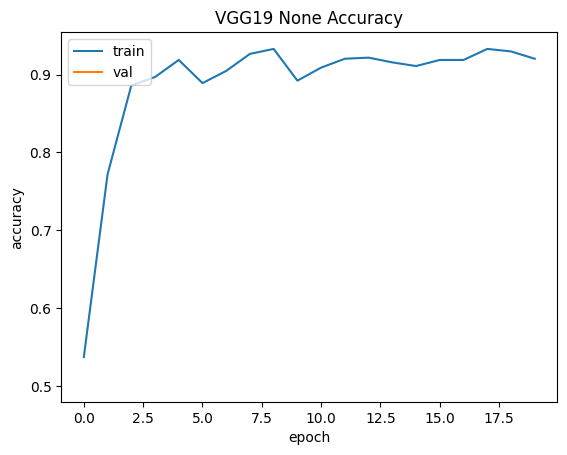

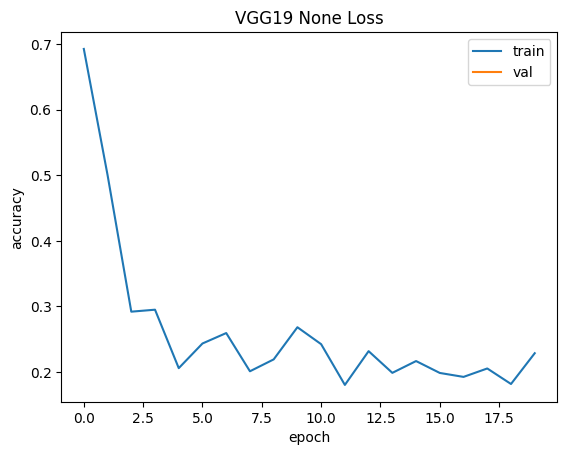

In [11]:
show_accuracy(history_VGG_nodr_prodr_data6, 'VGG19', 'None')
show_loss(history_VGG_nodr_prodr_data6, 'VGG19', 'None')

#### Prediction

In [12]:
y_pred = history_VGG_nodr_prodr_data6.model.predict(test_generator_nodr_prodr)

18/18 [==============================] - 69s 4s/step


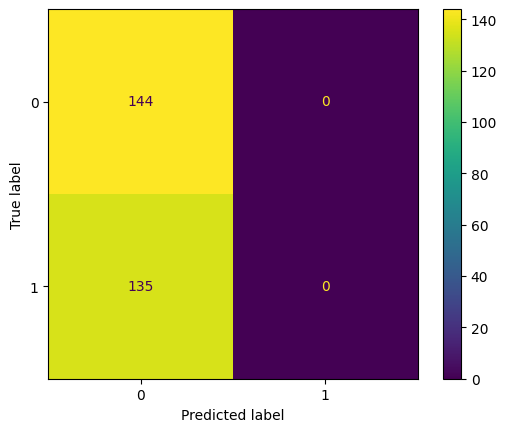

In [13]:
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator_nodr_prodr.classes

cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

### Pemanggilan Model VGG19

In [1]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

image_size = (224, 224) # Bisa kalian ganti#define input shape
labels = ['No DR', 'Proliferative DR']

In [2]:
MODEL_PATH = 'C:\Dani\Kuliah\TA\VGG19_nodr_prodr_data6.h5'

model = load_model(MODEL_PATH, compile=False)

In [3]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    return nimg
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

#### Uji 1 DR - No: 13 DR: 100

In [33]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 389ms/step
No DR:  13
DR:  100


#### Uji 2 No - No: 113 DR:5

In [7]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 310ms/step
No DR:  113
DR:  5


#### Uji 3 DR - No: 123 DR: 77

In [4]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 646ms/step
No DR:  123
DR:  77


#### Uji 4 DR - No: 163 DR: 37

In [5]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 579ms/step
No DR:  163
DR:  37


#### Uji 5 No - No: 164 DR: 36

In [8]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 409ms/step
No DR:  164
DR:  36


#### Uji 6 No - No: 159 DR: 41

In [7]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 712ms/step
No DR:  159
DR:  41


#### Uji 7 No - No: 190 DR: 10

In [47]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/test/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    print(label[35:-4], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 1s/step
01d9477b1171_png.rf.106ae9ee6cefce0575b1234ae9e33e3e  -  No DR  -  0.0
1/1 [==============================] - 1s 1s/step
01f7bb8be950_png.rf.f00e239651c17fdd19e79e43f923767c  -  No DR  -  0.7912109
1/1 [==============================] - 1s 1s/step
0212dd31f623_png.rf.028a049dec0104cc7507e305b3350ef1  -  No DR  -  0.0
1/1 [==============================] - 1s 987ms/step
02358b47ea89_png.rf.f2c9e8e7f05075be774dfaebd5b84e20  -  No DR  -  0.9998927
1/1 [==============================] - 1s 978ms/step
04aef84a2cc1_png.rf.8277e09e3432478ed982f918812b8468  -  No DR  -  0.0
1/1 [==============================] - 1s 946ms/step
054b1b305160_png.rf.6fb82a9515a2cefbb1dc7d754f5efc79  -  No DR  -  0.0
1/1 [==============================] - 1s 954ms/step
060e00d1e2ab_png.rf.7d0ddd2e457230c6d7cc877ee35875f5  -  No DR  -  0.0
1/1 [==============================] - 1s 1s/step
0773a1c326ad_png.rf.06aeab157f536f1d5181a05301d1385f  -  No DR  -  0.0
1/1 [===

### Development Phase : ResNet50 - Percobaan 6

In [14]:
input_shape = train_generator_nodr_prodr.image_shape

lr = 0.0001
steps_per_epoch = 40
epochs = 20
validation_steps = 30

In [15]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### MODEL

In [16]:
def residual_block(X_start, filters, name, reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[64, 64, 1]
def ResNet50(input_shape):
    # to make sure the len of the input shape is 3
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=1, activation=sigmoid)(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

#### Compile and Train Model

In [17]:
model_ResNet50_data6 = ResNet50(input_shape)
model_ResNet50_data6.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

In [18]:
start = time.time()

history_ResNet50_data6 = model_ResNet50_data6.fit(
      train_generator_nodr_prodr,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator_nodr_prodr,
      validation_steps = validation_steps,
      verbose=1)
end = time.time()
print("Time for learning: ", (end-start))

Epoch 1/20


40/40 [==============================] - 264s 6s/step - loss: 0.4964 - accuracy: 0.7987 - val_loss: 0.7013 - val_accuracy: 0.4982
Epoch 2/20
40/40 [==============================] - 217s 5s/step - loss: 0.3424 - accuracy: 0.8658
Epoch 3/20
40/40 [==============================] - 222s 6s/step - loss: 0.2794 - accuracy: 0.8938
Epoch 4/20
40/40 [==============================] - 223s 6s/step - loss: 0.3052 - accuracy: 0.8859
Epoch 5/20
40/40 [==============================] - 224s 6s/step - loss: 0.2527 - accuracy: 0.9125
Epoch 6/20
40/40 [==============================] - 221s 6s/step - loss: 0.2410 - accuracy: 0.9141
Epoch 7/20
40/40 [==============================] - 241s 6s/step - loss: 0.2110 - accuracy: 0.9141
Epoch 8/20
40/40 [==============================] - 233s 6s/step - loss: 0.2400 - accuracy: 0.9000
Epoch 9/20
40/40 [==============================] - 236s 6s/step - loss: 0.2061 - accuracy: 0.9172
Epoch 10/20
40/40 [==============================] - 238s 6s/step - loss: 0.24

#### Save Model

In [9]:
history_ResNet50_data6.model.save("ResNet50_nodr_pro_data6.h5")

C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Evaluate

In [19]:
ResNet50_loss, ResNet50_accuracy = history_ResNet50_data6.model.evaluate(train_generator_nodr_prodr, steps=40)
print("ResNet50 train loss : ", ResNet50_loss)
print("ResNet50 train accuracy : ", ResNet50_accuracy)

40/40 [==============================] - 60s 1s/step - loss: 0.2902 - accuracy: 0.9172
ResNet50 train loss :  0.2901532053947449
ResNet50 train accuracy :  0.917187511920929


In [20]:
ResNet50_loss, ResNet50_accuracy = history_ResNet50_data6.model.evaluate(test_generator_nodr_prodr, steps=40)
print("ResNet50 train loss : ", ResNet50_loss)
print("ResNet50 train accuracy : ", ResNet50_accuracy)

40/40 [==============================] - 27s 658ms/step - loss: 0.2095 - accuracy: 0.9283
ResNet50 train loss :  0.20946736633777618
ResNet50 train accuracy :  0.9283154010772705


In [21]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

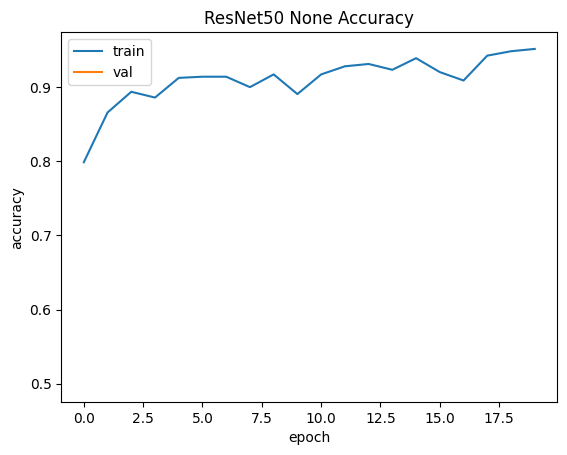

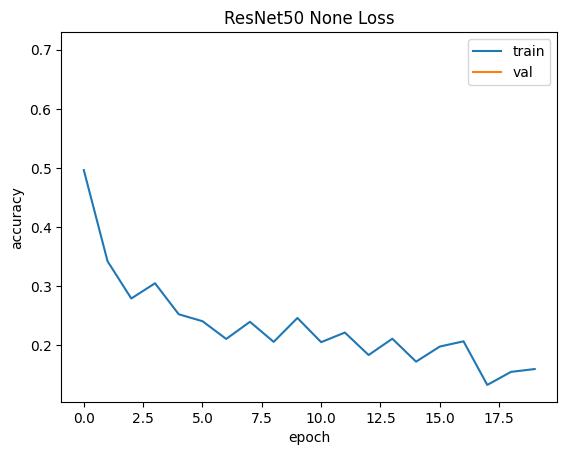

In [22]:
show_accuracy(history_ResNet50_data6, 'ResNet50', 'None')
show_loss(history_ResNet50_data6, 'ResNet50', 'None')

#### Prediction

In [23]:
y_pred = history_ResNet50_data6.model.predict(test_generator_nodr_prodr)

18/18 [==============================] - 28s 1s/step


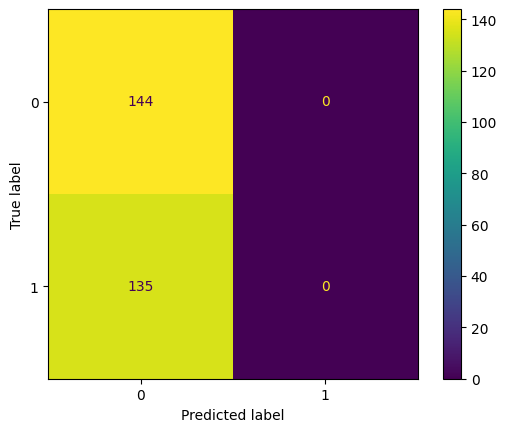

In [24]:
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator_nodr_prodr.classes

cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

### Pemanggilan Model ResNet50

In [9]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

image_size = (224, 224) # Bisa kalian ganti#define input shape
labels = ['No DR', 'Proliferative DR']

In [10]:
MODEL_PATH = 'C:\Dani\Kuliah\TA\ResNet50_nodr_pro_data6.h5'

model = load_model(MODEL_PATH, compile=False)

In [11]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    return nimg
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

#### Uji 1 DR - No: 113 DR: 0

In [30]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 253ms/step
No DR:  113
DR:  0


#### Uji 2 No - No: 118 DR: 0

In [32]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    print(y)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 290ms/step
[[0.]]
1/1 [==============================] - 0s 252ms/step
[[0.]]
1/1 [==============================] - 0s 264ms/step
[[0.]]
1/1 [==============================] - 0s 356ms/step
[[0.]]
1/1 [==============================] - 0s 440ms/step
[[0.]]
1/1 [==============================] - 0s 289ms/step
[[0.]]
1/1 [==============================] - 0s 289ms/step
[[0.]]
1/1 [==============================] - 0s 396ms/step
[[0.]]
1/1 [==============================] - 0s 379ms/step
[[0.]]
1/1 [==============================] - 0s 473ms/step
[[0.]]
1/1 [==============================] - 0s 368ms/step
[[0.]]
1/1 [==============================] - 0s 308ms/step
[[0.]]
1/1 [==============================] - 0s 492ms/step
[[0.]]
1/1 [==============================] - 0s 491ms/step
[[0.]]
1/1 [==============================] - 0s 492ms/step
[[0.]]
1/1 [==============================] - 0s 478ms/step
[[0.]]
1/1 [==============================] - 0

#### Uji 3 DR - No: 200 DR: 0

In [12]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 251ms/step
No DR:  200
DR:  0


#### Uji 4 DR - No: 200 DR: 0

In [13]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 269ms/step
No DR:  200
DR:  0


#### Uji 5 No - No: 200 DR: 0

In [14]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 590ms/step
No DR:  200
DR:  0


#### Uji 6 No - No: 200 DR: 0

In [15]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 641ms/step
No DR:  200
DR:  0


#### Uji 7 No - No: 200 DR: 0

In [25]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/test/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    print(label[35:-4], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 255ms/step
01d9477b1171_png.rf.106ae9ee6cefce0575b1234ae9e33e3e  -  No DR  -  0.0
1/1 [==============================] - 0s 200ms/step
01f7bb8be950_png.rf.f00e239651c17fdd19e79e43f923767c  -  No DR  -  0.0
1/1 [==============================] - 0s 309ms/step
0212dd31f623_png.rf.028a049dec0104cc7507e305b3350ef1  -  No DR  -  0.0
1/1 [==============================] - 0s 219ms/step
02358b47ea89_png.rf.f2c9e8e7f05075be774dfaebd5b84e20  -  No DR  -  0.0
1/1 [==============================] - 0s 336ms/step
04aef84a2cc1_png.rf.8277e09e3432478ed982f918812b8468  -  No DR  -  0.0
1/1 [==============================] - 0s 309ms/step
054b1b305160_png.rf.6fb82a9515a2cefbb1dc7d754f5efc79  -  No DR  -  0.0
1/1 [==============================] - 0s 299ms/step
060e00d1e2ab_png.rf.7d0ddd2e457230c6d7cc877ee35875f5  -  No DR  -  0.0
1/1 [==============================] - 0s 306ms/step
0773a1c326ad_png.rf.06aeab157f536f1d5181a05301d1385f  -  No DR  -  0.0
1/1 [===

### Development Phase : VGG19 - Percobaan 7

In [4]:
input_shape = train_generator_nodr_prodr.image_shape

lr = 0.0001
steps_per_epoch = 40
epochs = 30
validation_steps = 40

In [5]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### MODEL

In [6]:
def VGG19 (input_shape) :

    x_input = Input(input_shape, name="input_layer") #VGG19 input_shape by default is (64,64,1)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1")(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1")(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1")(x) #1
    x = Dense(4096, activation=relu, name="fc2")(x) #2
    x = Dense(1, activation=sigmoid, name="predictions")(x) #3
    #n_class = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG19")

    return model

#### Compile and Training

In [7]:
model_VGG = VGG19(input_shape)
model_VGG.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

In [8]:
start = time.time()
history_VGG_nodr_prodr_data6 = model_VGG.fit(
      train_generator_nodr_prodr,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator_nodr_prodr,
      validation_steps = validation_steps,
      verbose=1)
end = time.time()
print("Time for learning: ", (end-start))

Epoch 1/30


40/40 [==============================] - 685s 17s/step - loss: 0.6185 - accuracy: 0.6531 - val_loss: 0.3241 - val_accuracy: 0.8807
Epoch 2/30
40/40 [==============================] - 582s 15s/step - loss: 0.3242 - accuracy: 0.8754
Epoch 3/30
40/40 [==============================] - 586s 15s/step - loss: 0.2598 - accuracy: 0.9062
Epoch 4/30
40/40 [==============================] - 591s 15s/step - loss: 0.2687 - accuracy: 0.8938
Epoch 5/30
40/40 [==============================] - 594s 15s/step - loss: 0.2488 - accuracy: 0.9062
Epoch 6/30
40/40 [==============================] - 558s 14s/step - loss: 0.2142 - accuracy: 0.9121
Epoch 7/30
40/40 [==============================] - 560s 14s/step - loss: 0.1976 - accuracy: 0.9234
Epoch 8/30
40/40 [==============================] - 558s 14s/step - loss: 0.2192 - accuracy: 0.9297
Epoch 9/30
40/40 [==============================] - 557s 14s/step - loss: 0.2092 - accuracy: 0.9328
Epoch 10/30
40/40 [==============================] - 557s 14s/step - 

#### Save Model

In [9]:
history_VGG_nodr_prodr_data6.model.save("VGG19_nodr_prodr_data6_try2.h5")

C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Evaluate

In [9]:
# loaded_vgg16 = load_model('VGG16.h5')

VGG16_loss, VGG16_accuracy = history_VGG_nodr_prodr_data6.model.evaluate(train_generator_nodr_prodr, steps=50)
print("VGG19 train loss : ", VGG16_loss)
print("VGG19 train accuracy : ", VGG16_accuracy)

50/50 [==============================] - 188s 4s/step - loss: 0.1876 - accuracy: 0.9300
VGG19 train loss :  0.18760798871517181
VGG19 train accuracy :  0.9300000071525574


In [10]:
VGG16_loss, VGG16_accuracy = history_VGG_nodr_prodr_data6.model.evaluate(test_generator_nodr_prodr, steps=50)
print("VGG19 train loss : ", VGG16_loss)
print("VGG19 train accuracy : ", VGG16_accuracy)

50/50 [==============================] - 66s 1s/step - loss: 0.1341 - accuracy: 0.9534
VGG19 train loss :  0.1340954750776291
VGG19 train accuracy :  0.9534050226211548


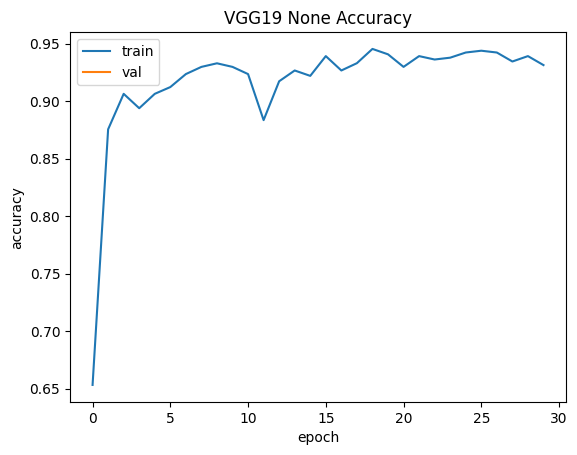

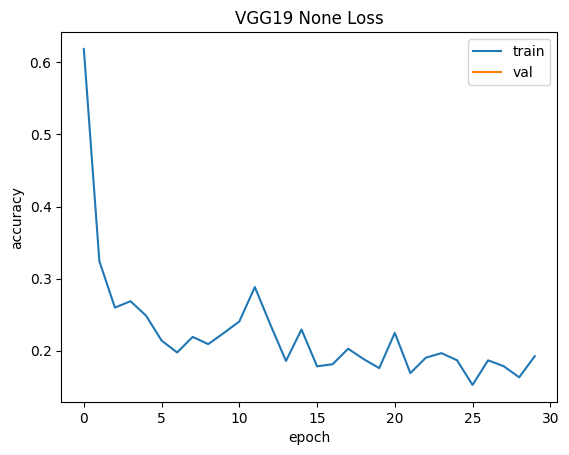

In [11]:
show_accuracy(history_VGG_nodr_prodr_data6, 'VGG19', 'None')
show_loss(history_VGG_nodr_prodr_data6, 'VGG19', 'None')

#### Prediction

In [12]:
y_pred = history_VGG_nodr_prodr_data6.model.predict(test_generator_nodr_prodr)

18/18 [==============================] - 65s 4s/step


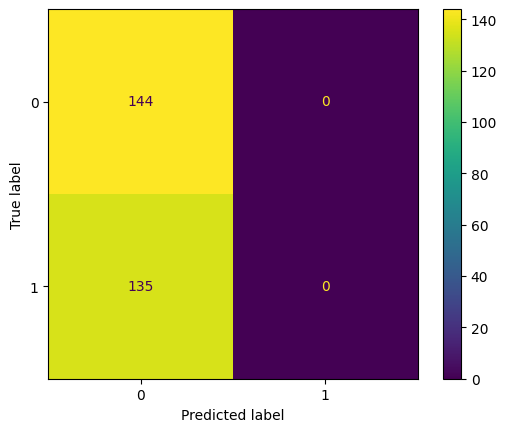

In [13]:
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator_nodr_prodr.classes

cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

### Pemanggilan VGG19

In [16]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

image_size = (224, 224) # Bisa kalian ganti#define input shape
labels = ['No DR', 'Proliferative DR']

In [17]:
MODEL_PATH = 'C:\Dani\Kuliah\TA\VGG19_nodr_prodr_data6_try2.h5'

model = load_model(MODEL_PATH, compile=False)

In [18]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    return nimg
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

#### Uji 1 DR - No: 21 DR: 92

In [18]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 320ms/step
No DR:  21
DR:  92


#### Uji 2 No - No: 116 DR: 2

In [19]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 313ms/step
No DR:  116
DR:  2


#### Uji 3 DR - No: 174 DR: 26

In [19]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 987ms/step
No DR:  174
DR:  26


#### Uji 4 DR - No: 186 DR: 14

In [20]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 879ms/step
No DR:  186
DR:  14


#### Uji 5 No - No: 179 DR: 21

In [21]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 2s 2s/step
No DR:  179
DR:  21


#### Uji 6 No - No: 187 DR: 13

In [22]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 1s/step
No DR:  187
DR:  13


#### Uji 7 No - No: 195 DR: 5

In [23]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/test/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    print(label[35:-4], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 487ms/step
01d9477b1171_png.rf.106ae9ee6cefce0575b1234ae9e33e3e  -  No DR  -  0.0
1/1 [==============================] - 0s 420ms/step
01f7bb8be950_png.rf.f00e239651c17fdd19e79e43f923767c  -  No DR  -  0.0
1/1 [==============================] - 0s 428ms/step
0212dd31f623_png.rf.028a049dec0104cc7507e305b3350ef1  -  No DR  -  0.0
1/1 [==============================] - 0s 408ms/step
02358b47ea89_png.rf.f2c9e8e7f05075be774dfaebd5b84e20  -  No DR  -  0.0
1/1 [==============================] - 0s 417ms/step
04aef84a2cc1_png.rf.8277e09e3432478ed982f918812b8468  -  No DR  -  0.0
1/1 [==============================] - 0s 429ms/step
054b1b305160_png.rf.6fb82a9515a2cefbb1dc7d754f5efc79  -  No DR  -  0.0
1/1 [==============================] - 0s 420ms/step
060e00d1e2ab_png.rf.7d0ddd2e457230c6d7cc877ee35875f5  -  No DR  -  0.0
1/1 [==============================] - 0s 421ms/step
0773a1c326ad_png.rf.06aeab157f536f1d5181a05301d1385f  -  No DR  -  0.0
1/1 [===